# Pattern extraction
more information to why and how can be found in the README

In [218]:
import re
import collections
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk

from collections import Counter

In [219]:

df = pd.read_csv('../datasets/raw/2020_06_23_CE-BVerwG_DE_Datensatz.csv')

### preprocessing

In [186]:
kuerzel = pd.read_csv('../src/data/gesetzbuch_abbreviations.csv')['abbreviation'].tolist()
minidf = df.sample(frac = 0.05)
minidf['text_normalized'] = minidf['text'].str.replace("\n", " ")\
    .replace("(" + "|".join(kuerzel) + ")", "<gesetzbuch>", regex=True).str.lower()\
    .replace('\s+', ' ', regex=True)\
    .replace("[0-9]+", "<number>", regex=True)\
    .replace("(januar|februar|märz|april|mai|juni|juli|august|september|oktober|november|dezember)", "<monat>", regex=True)\
    .str.replace("<number>. <monat> <number>", "<datum>")


In [187]:
vocab = nltk.lm.Vocabulary(minidf['text_normalized'], unk_cutoff=10)
data = []
for judgement in minidf['text_normalized']:
    data.extend(judgement.split(" "))
filtered_data = [word for word in data if len(word) > 1 or not word.isalpha()]

In [188]:
len(minidf)

1211

In [194]:
def compute_top_phrase_frequencies(min_len, max_len=None):
    """ computes all ngrams and selects the 1000 most frequent ngrams"""
    if not max_len:
        max_len = min_len
    longgrams = list(nltk.everygrams(filtered_data, min_len, max_len))
    most_common = Counter(longgrams)
    most_common = most_common.most_common(1000)
    return most_common

In [192]:
minlen = 4
maxlen = 150
common_phrases = {}
for i in tqdm(range(minlen, maxlen)):
    common_phrases[i] = compute_top_phrase_frequencies(i)


100%|██████████| 96/96 [04:46<00:00,  2.99s/it]


In [205]:
def filter_duplicate_phrases(most_common, minlen, maxlen, top_n=10) -> (list, list, list):
    """ many frequent ngrams are similar verions of each other.
    In order to show unique patterns one must filter out the similar ones
    Args:
        most_common dict(int: list(list(str))): this dict contains the detectedcommon ngrams
            these are seperated by the length of the ngram. they key is the length of the 
            ngram and value is the list of ngrams at this length.
        top_n (int): max number of ngrams to keep per ngram length after filtering
        """
    phrases = []
    frequencies = []
    lengths = []
    
    # selects subset of all most_common ngrams
    # this facilitates visualization 
    selected_keys = [key for key in list(most_common.keys()) 
                      if key < maxlen and key > minlen]

    for length in selected_keys[::-1]:  # iterate over ngrams of length 'length'
        counter = 0
        previous_frequencies = []
        
        for phrase, frequency in most_common[length]:
            phrase_candidate = " ".join(phrase)

            # only add to list of patterns if phrase is new or if 
            # it is a substring of an existing pattern but occurs 2x more frequently
            unseen_pattern = True
            for i in range(len(phrases)):
                if phrase_candidate in phrases[i] and frequency <= frequencies[i]*2:
                    unseen_pattern = False
                    break
            
            if unseen_pattern and frequency not in previous_frequencies:
                phrases.append(phrase_candidate)
                lengths.append(length)
                
                frequencies.append(frequency)
                counter += 1
                if counter >= top_n:
                    break
                

    return phrases, frequencies, lengths

In [211]:
def plot_result(phrases, frequencies, lengths):
    fig = plt.figure(figsize =(8,8))
    plt.title("most common ngrams")

    plt.ylabel("frequency")
    plt.xlabel("lenth of ngrams in words")
    plt.scatter(lengths, frequencies)
    plt.show()


def print_result(phrases, frequencies, lengths):
    for i in range(len(phrases)):
        print("freq: ", frequencies[i], "length", lengths[i])
        print(phrases[i])
        print("")

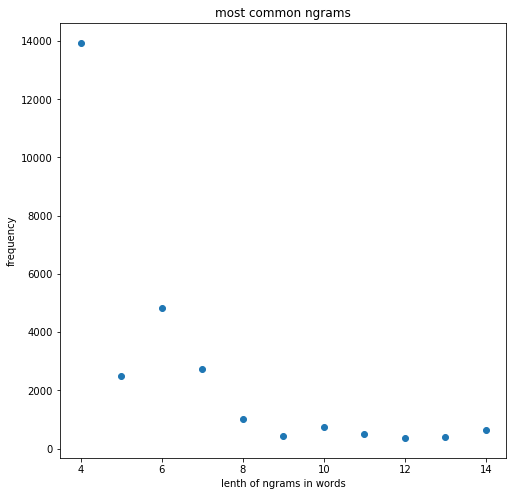

In [216]:
phrases, frequencies, lengths = filter_duplicate_phrases(common_phrases, 2, 15, 1)
plot_result(phrases, frequencies, lengths)


In [217]:
print_result(phrases, frequencies, lengths)

freq:  643 length 14
hat der <number>. senat des bundesverwaltungsgerichts am <datum> durch den vorsitzenden richter am bundesverwaltungsgericht

freq:  400 length 13
in der verwaltungsstreitsache -<number>- hat der <number>. senat des bundesverwaltungsgerichts am <datum> durch

freq:  366 length 12
in der verwaltungsstreitsache hat der <number>. senat des bundesverwaltungsgerichts am <datum> durch

freq:  510 length 11
vom <datum> - bverwg <number> <number>.<number> - buchholz <number> § <number>

freq:  757 length 10
vom <datum> - bverwg <number> <number>.<number> - bverwge <number>, <number>

freq:  438 length 9
vom <datum> - bverwg <number> <number>.<number> - buchholz <number>.<number>

freq:  1036 length 8
vom <datum> - bverwg <number> <number>.<number> - buchholz

freq:  2734 length 7
vom <datum> - bverwg <number> <number>.<number> -

freq:  4836 length 6
§ <number> abs. <number> satz <number>

freq:  2496 length 5
des § <number> abs. <number>

freq:  13942 length 4
§ <number> a

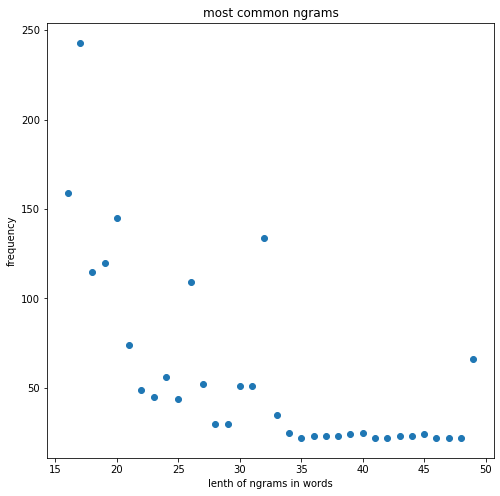

In [214]:
phrases, frequencies, lengths = filter_duplicate_phrases(common_phrases, 15, 50, 1)
plot_result(phrases, frequencies, lengths)


In [215]:
print_result(phrases, frequencies, lengths)

freq:  66 length 49
<number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>, <number>,

freq:  22 length 48
sich durch einen rechtsanwalt oder einen rechtslehrer an einer deutschen hochschule im sinne des hochschulrahmengesetzes mit befähigung zum richteramt als bevollmächtigten vertreten lassen. juristische personen des öffentlichen rechts und behörden können sich auch durch beamte oder angestellte mit befähigung zum richteramt sowie diplomjuristen im höheren dienst, gebietskörperschaften ferner

freq:  22 length 47
einen rechtsanwalt oder einen rechtslehrer an einer de

In [225]:
phrases, frequencies, lengths = filter_duplicate_phrases(common_phrases, 50, 100, 1)
print_result(phrases, frequencies, lengths)

freq:  17 length 99
für den revisionskläger besteht vertretungszwang; dies gilt auch für die begründung der revision. der revisionskläger muss sich durch einen rechtsanwalt oder einen rechtslehrer an einer deutschen hochschule im sinne des hochschulrahmengesetzes mit befähigung zum richteramt als bevollmächtigten vertreten lassen. juristische personen des öffentlichen rechts und behörden können sich auch durch beamte oder angestellte mit befähigung zum richteramt sowie diplomjuristen im höheren dienst, gebietskörperschaften ferner durch beamte oder angestellte mit befähigung zum richteramt der zuständigen aufsichtsbehörde oder des jeweiligen kommunalen spitzenverbandes des landes, dem sie als mitglied zugehören, vertreten lassen. in derselben weise muss sich jeder beteiligte vertreten lassen, soweit

freq:  17 length 98
revisionskläger besteht vertretungszwang; dies gilt auch für die begründung der revision. der revisionskläger muss sich durch einen rechtsanwalt oder einen rechtslehrer

## Other statistics on datasets

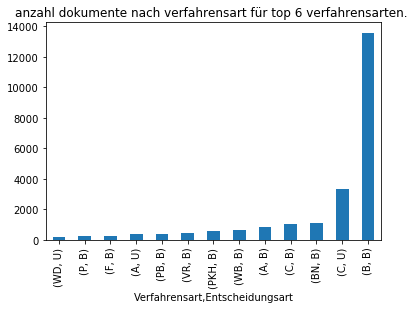

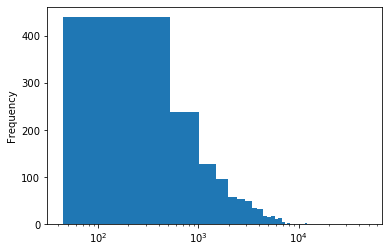

In [220]:
plt.title("anzahl dokumente nach verfahrensart für top 6 verfahrensarten. ")
subset = df.groupby(['Verfahrensart', 'Entscheidungsart']).size()
subset[subset > 200].sort_values().plot(kind='bar')
plt.show()
count = minidf['text'].str.split(" ").apply(len).sort_values()
plt.xscale("log")
count.plot.hist(bins=100)
plt.show()

In [31]:
from pyspark.ml.fpm import PrefixSpan
from pyspark import SparkContext

sc = SparkContext.getOrCreate();
plist = minidf['text_normalized'].tolist()
rdd = sc.parallelize(plist)
#df = spark.createDataFrame(rdd)

In [32]:
prefixSpan = PrefixSpan(minSupport=0.5, maxPatternLength=20,
                        maxLocalProjDBSize=3200000)

# Find frequent sequential patterns.
prefixSpan.findFrequentSequentialPatterns(rdd).show()

AttributeError: 'RDD' object has no attribute '_jdf'